In [2]:
import sys
# append the path of the parent directory
sys.path.append("..")

In [112]:
import math
import os
import time


import numpy as np
np.set_printoptions(legacy='1.25')

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

import seaborn as sns
import time
import json
import pandas as pd
from ctypes import c_int32
from itertools import product
import copy


from tqdm import tqdm

from scipy.stats import pearsonr
from importlib import reload

import orjson
import gzip

from scipy.stats import entropy
from pympler import asizeof

from lib import sketches, visualization_utils, encoders, ploting, pacha_sketch
reload(ploting)
reload(sketches)
reload(visualization_utils)
reload(encoders)

reload(pacha_sketch)

from lib.sketches import BloomFilter, CountMinSketch, H3HashFunctions, HashFunctionFamily,\
      CountMinSketchHadamard, CountMinSketchLocalHashing, deterministic_hash, simple_deterministic_hash, \
      fast_hash_xx
from lib.visualization_utils import plot_boxplot

from lib.encoders import minimal_b_adic_cover, minimal_spatial_b_adic_cover, BAdicCube, BAdicRange, \
      minimal_b_adic_cover_array, downgrade_b_adic_range_indices
from lib.pacha_sketch import PachaSketch, ADTree, BFParameters, CMParameters, \
      cartesian_product, get_n_updates, MaterializedCombinations, get_n_updates_customized

from lib.ploting import set_style, plot_ylabel, plot_legend

from lib import baselines
reload(baselines)

from lib.baselines import CentralDPServer, LDPServer, LDPEncoderGRR, filter_df, query_df, \
      infer_domains_and_ranges, translate_query_region, evaluate_queries, check_accruracy, \
      evaluate_queries_baselines, evaluate_equivalent_pacha_sketches, compute_relative_entropy

# set_style()

In [64]:
def remove_ourliers(result_df):
    q1 = result_df['normalized_error'].quantile(0.25)
    q3 = result_df['normalized_error'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    result_df_no_outliers = result_df[(result_df['normalized_error'] >= lower_bound) & (result_df['normalized_error'] <= upper_bound)].copy()
    return result_df_no_outliers

## Lineitem Scale

In [59]:
scale_factors = 4**np.arange(4) * 0.03125
n_elements = ['187 k', '750 k', '3 M', '12 M']

results = []
for sf, n in zip(scale_factors, n_elements):
    result_df = pd.read_csv(f"../results/tpch/scale/tpch_random_results_2_{sf}.csv")
    result_df_2 = pd.read_csv(f"../results/tpch/scale/tpch_random_results_{sf}.csv")
    result_df = pd.concat([result_df, result_df_2], ignore_index=True)
    result_df['approach'] = n
    results.append(result_df)

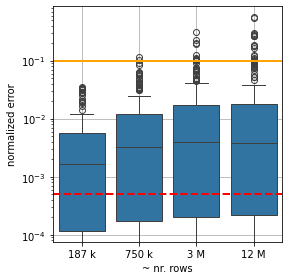

In [60]:
custom_palette = {
    '187 k': 'tab:blue',
    '750 k': 'tab:blue',
    '3 M': 'tab:blue',
    '12 M': 'tab:blue',
}
plot_boxplot(results, target=0.0005, log_scale=True, x_label='~ nr. rows', figsize=(4, 4), palette=custom_palette)

In [65]:
rel_entropies = []
rel_entropies_no_outliers = []
for result_df in results:
    rel_entropies.append(compute_relative_entropy(result_df))
    rel_entropies_no_outliers.append(compute_relative_entropy(remove_ourliers(result_df)))

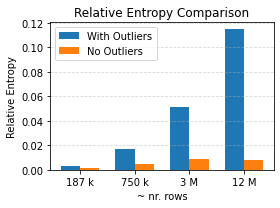

In [73]:
labels = n_elements
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(4, 3))
rects1 = ax.bar(x - width/2, rel_entropies, width, label='With Outliers')
rects2 = ax.bar(x + width/2, rel_entropies_no_outliers, width, label='No Outliers')

ax.set_ylabel('Relative Entropy')
ax.set_xlabel('~ nr. rows')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
ax.set_title('Relative Entropy Comparison')

plt.tight_layout()
plt.show()

In [85]:
rel_eps = 0.0005
levels = 5
delta = 0.01
bloom_p = 0.01
cat_col_map_tpch = [0, 1, 2, 3, 4]
n_cat_tpch = len(cat_col_map_tpch)
num_col_map_tpch = [5, 6, 7, 8, 9]
n_num_tpch = len(num_col_map_tpch)
bases_tpch = [5,5,5,10,2]

ad_tree_levels = len(cat_col_map_tpch)
num_combinations = 13
cat_updates_tpch, num_updates_tpch, region_updates_tpch = get_n_updates_customized(ad_tree_levels, num_combinations, levels)

error_eps = rel_eps / region_updates_tpch
sizes = []
for len_df in (4**np.arange(4) * 187500):
    size_details = []
    size_details.append(BFParameters(n_values=len_df * num_updates_tpch, p=bloom_p).peek_memory())
    size_details.append(BFParameters(n_values=len_df * region_updates_tpch, p=bloom_p).peek_memory())
    cm_size = CMParameters(delta=delta, error_eps=error_eps).peek_memory()
    size_details.append(cm_size * (levels - 1))
    size_details.append(cm_size)
    sizes.append(size_details)
sizes = np.array(sizes)

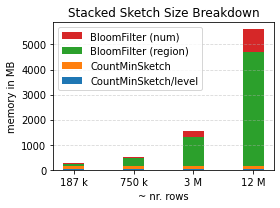

In [94]:
fig, ax = plt.subplots(figsize=(4, 3))
bottom = np.zeros(sizes.shape[0])
labels_stack = ['BloomFilter (num)', 'BloomFilter (region)', 'CountMinSketch', 'CountMinSketch/level']

for i in reversed(range(sizes.shape[1])):
    ax.bar(x, sizes[:, i], width, bottom=bottom, label=labels_stack[i])
    bottom += sizes[:, i]

ax.set_ylabel('memory in MB')
ax.set_xlabel('~ nr. rows')
ax.set_xticks(x)
ax.set_xticklabels(n_elements)
handles, legend_labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], legend_labels[::-1])
# plt.yscale('log')
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
plt.title('Stacked Sketch Size Breakdown')
plt.tight_layout()
plt.show()

## Sketch Size

In [146]:
probs = 2**np.arange(7)*0.005
rel_epsilons = 2**np.arange(7) * 0.00025

labels = [f'p={p}, ε={eps}' for p, eps in zip(probs, rel_epsilons)]

results = []
for label, p, eps in zip(labels, probs, rel_epsilons):
    result_df = pd.read_csv(f"../results/tpch/size/tpch_random_results_0.1_eps_{eps}_p_{p}.csv")
    result_df_2 = pd.read_csv(f"../results/tpch/size/tpch_random_results_2_0.1_eps_{eps}_p_{p}.csv")
    result_df = pd.concat([result_df, result_df_2], ignore_index=True)
    result_df['approach'] = label
    results.append(result_df)

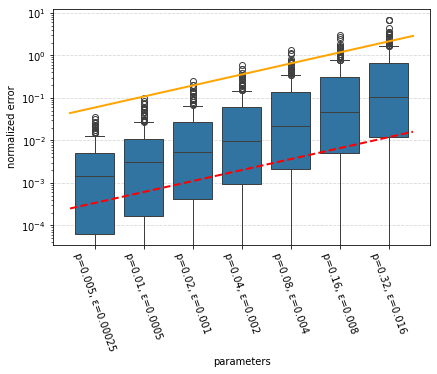

In [147]:
custom_palette = {}
for label in labels:
    custom_palette[label] = 'tab:blue'
plot_boxplot(results, log_scale=True, rotation=-70, target=rel_epsilons, x_label='parameters', figsize=(6, 4), palette=custom_palette)

In [115]:
rel_entropies = []
rel_entropies_no_outliers = []
for result_df in results:
    rel_entropies.append(compute_relative_entropy(result_df))
    rel_entropies_no_outliers.append(compute_relative_entropy(remove_ourliers(result_df)))

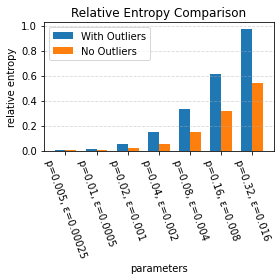

In [120]:
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(4, 4))
rects1 = ax.bar(x - width/2, rel_entropies, width, label='With Outliers')
rects2 = ax.bar(x + width/2, rel_entropies_no_outliers, width, label='No Outliers')

ax.set_ylabel('relative entropy')
ax.set_xlabel('parameters')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
ax.set_title('Relative Entropy Comparison')
plt.xticks(rotation=-70, ha='center')

plt.tight_layout()
plt.show()

In [121]:
lineitem_df = pd.read_parquet("../data/tpch/lineitem_0.1.parquet")
len_df = len(lineitem_df)

levels = 5
delta = 0.01
cat_col_map_tpch = [0, 1, 2, 3, 4]
n_cat_tpch = len(cat_col_map_tpch)
num_col_map_tpch = [5, 6, 7, 8, 9]
n_num_tpch = len(num_col_map_tpch)
bases_tpch = [5,5,5,10,2]

ad_tree_levels = len(cat_col_map_tpch)
num_combinations = 13
cat_updates_tpch, num_updates_tpch, region_updates_tpch = get_n_updates_customized(ad_tree_levels, num_combinations, levels)

sizes = []
for bloom_p, rel_eps in zip(probs, rel_epsilons):
    error_eps = rel_eps / region_updates_tpch
    size_details = []
    size_details.append(BFParameters(n_values=len_df * num_updates_tpch, p=bloom_p).peek_memory())
    size_details.append(BFParameters(n_values=len_df * region_updates_tpch, p=bloom_p).peek_memory())
    cm_size = CMParameters(delta=delta, error_eps=error_eps).peek_memory()
    size_details.append(cm_size * (levels - 1))
    size_details.append(cm_size)
    sizes.append(size_details)
sizes = np.array(sizes)

In [ ]:
BFParameters(n_values=len_df * region_updates_tpch, p=bloom_p).peek_memory()

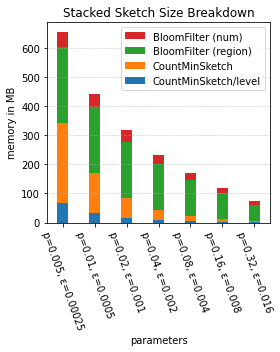

In [125]:
fig, ax = plt.subplots(figsize=(4, 5))
bottom = np.zeros(sizes.shape[0])
labels_stack = ['BloomFilter (num)', 'BloomFilter (region)', 'CountMinSketch', 'CountMinSketch/level']

for i in reversed(range(sizes.shape[1])):
    ax.bar(x, sizes[:, i], width, bottom=bottom, label=labels_stack[i])
    bottom += sizes[:, i]

ax.set_ylabel('memory in MB')
ax.set_xlabel('parameters')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation=-70, ha='center')
handles, legend_labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], legend_labels[::-1])
# plt.yscale('log')
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
plt.title('Stacked Sketch Size Breakdown')
plt.tight_layout()
plt.show()

## Different Queries

In [126]:
selectivities = np.array([0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64])

results = []
for sel in selectivities:
    result_df = pd.read_csv(f"../results/tpch/selectivities/tpch_sel_{sel}.csv")
    result_df['approach'] = sel
    results.append(result_df)

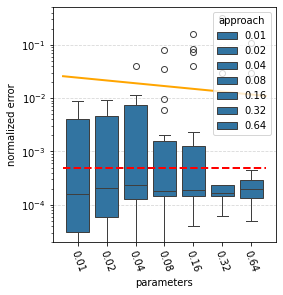

In [128]:
rel_epsilons = np.full(len(selectivities), 0.0005)
custom_palette = {}
for sel in selectivities:
    custom_palette[sel] = 'tab:blue'
plot_boxplot(results, log_scale=True, rotation=-70, target=rel_epsilons, x_label='parameters', figsize=(4, 4), palette=custom_palette)

In [138]:
n_dims = np.arange(1, 6)

results = []
for n in n_dims:
    result_df = pd.read_csv(f"../results/tpch/categorical/tpch_cat_{n}.csv")
    result_df['approach'] = n
    results.append(result_df)

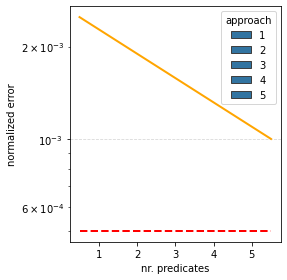

In [139]:
rel_epsilons = np.full(len(n_dims), 0.0005)
custom_palette = {}
for n in n_dims:
    custom_palette[n] = 'tab:blue'
plot_boxplot(results, log_scale=True, target=rel_epsilons, x_label='nr. predicates', figsize=(4, 4), palette=custom_palette)

In [140]:
n_dims = np.arange(1, 6)

results = []
for n in n_dims:
    result_df = pd.read_csv(f"../results/tpch/numerical/tpch_num_{n}.csv")
    result_df['approach'] = n
    results.append(result_df)

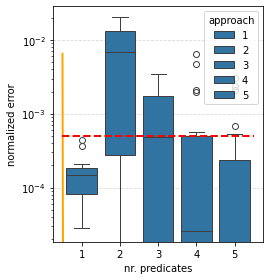

In [141]:
rel_epsilons = np.full(len(n_dims), 0.0005)
custom_palette = {}
for n in n_dims:
    custom_palette[n] = 'tab:blue'
plot_boxplot(results, log_scale=True, target=rel_epsilons, x_label='nr. predicates', figsize=(4, 4), palette=custom_palette)

In [142]:
n_dims = np.arange(1, 6)

results = []
for n in n_dims:
    result_df = pd.read_csv(f"../results/tpch/mixed/tpch_mix_{n}.csv")
    result_df['approach'] = 2*n
    results.append(result_df)

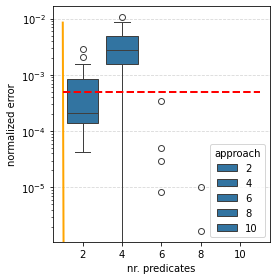

In [144]:
rel_epsilons = np.full(len(n_dims), 0.0005)
custom_palette = {}
for n in n_dims:
    custom_palette[2*n] = 'tab:blue'
plot_boxplot(results, log_scale=True, target=rel_epsilons, x_label='nr. predicates', figsize=(4, 4), palette=custom_palette)

In [ ]:
chunks = np.array_split(lineitem_df, 10)

/home/rudi/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [181]:
region_updates_tpch

330

In [185]:
2**np.arange(6) * 64 

array([  64,  128,  256,  512, 1024, 2048])

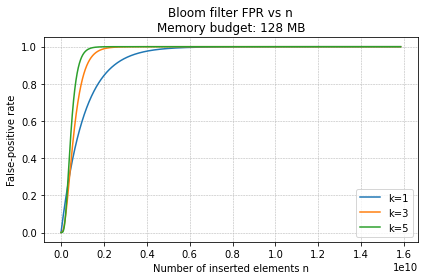

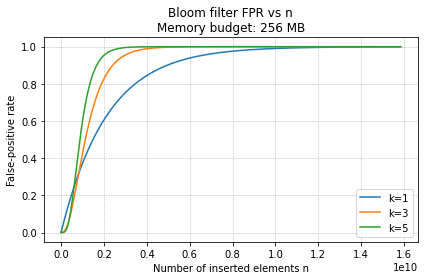

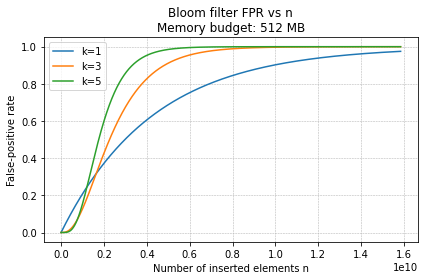

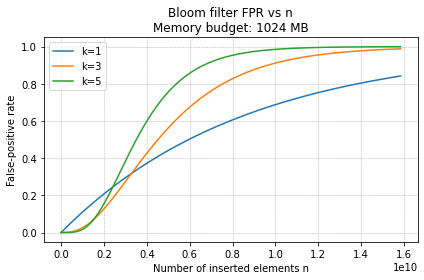

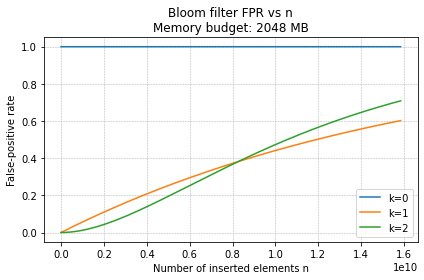

In [180]:
import numpy as np
import matplotlib.pyplot as plt

# --- Helper functions --------------------------------------------------------

def optimal_k(m_bits: int, n_items: int) -> float:
    """
    Optimal number of hash functions for a classic Bloom filter
    given bit‑array size m (in bits) and expected element count n.
    
    k = (m / n) * ln 2
    """
    from math import log
    return (m_bits / n_items) * log(2)

def false_positive_rate(m_bits: int, k: int, n_items: np.ndarray) -> np.ndarray:
    """
    Vectorised computation of Bloom filter false‑positive rate:
    
        f(n) = (1 - exp(-k * n / m)) ** k
    """
    return (1 - np.exp(-k * n_items / m_bits)) ** k

# --- Parameters you can tweak -----------------------------------------------

mem_budgets = 2**np.arange(5) * 128.0 * 8 * 1024 * 1024
for m_bits in mem_budgets:
    n_elements = 48_000_000
    n_updates = region_updates_tpch * n_elements
    n_values = np.linspace(1, n_updates, 500_000)
    k_opt = int(optimal_k(m_bits, (n_updates // 2)))
    if k_opt < 1:
        k_opt = 3
    k_low = k_opt // 2
    k_high = k_opt + (k_opt - k_low)

    fp_values_low = false_positive_rate(m_bits, k_low, n_values)
    fp_values_opt = false_positive_rate(m_bits, k_opt, n_values)
    fp_values_high = false_positive_rate(m_bits, k_high, n_values)
    
    plt.figure(figsize=(6, 4))
    plt.plot(n_values, fp_values_low, label=f'k={k_low}')
    plt.plot(n_values, fp_values_opt, label=f'k={k_opt}')
    plt.plot(n_values, fp_values_high, label=f'k={k_high}')
    plt.xlabel("Number of inserted elements n")
    plt.ylabel("False‑positive rate")
    plt.title(f"Bloom filter FPR vs n\nMemory budget: {m_bits / 8 / 1024 / 1024:.0f} MB")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [196]:
sum(workers)

31

In [197]:
2**np.arange(6) * 64

array([  64,  128,  256,  512, 1024, 2048])

In [192]:
mem_budgets = 2**np.arange(6) * 64.0 * 8 * 1024 * 1024
for m_bits in mem_budgets:
    p_num_index = num_updates_tpch / (num_updates_tpch + region_updates_tpch)
    p_region_index = 1.0 - p_num_index

    n_bits_num_index = int(np.ceil(m_bits * p_num_index))
    n_bits_region_index = int(np.ceil(m_bits * p_region_index))

    n_star_num = n_bits_num_index / 3 * np.log(2)
    n_star_region = n_bits_region_index / 3 * np.log(2)
    print(f"Memory budget: {m_bits / 8 / 1024 / 1024:.0f} MB")
    print(f"Number of elements for num index: {n_star_num/num_updates_tpch:,.0f}")
    print(f"Number of elements for region index: {n_star_region/region_updates_tpch:,.0f}\n")


Memory budget: 64 MB
Number of elements for num index: 313,241
Number of elements for region index: 313,241

Memory budget: 128 MB
Number of elements for num index: 626,482
Number of elements for region index: 626,482

Memory budget: 256 MB
Number of elements for num index: 1,252,965
Number of elements for region index: 1,252,965

Memory budget: 512 MB
Number of elements for num index: 2,505,930
Number of elements for region index: 2,505,930

Memory budget: 1024 MB
Number of elements for num index: 5,011,859
Number of elements for region index: 5,011,859

Memory budget: 2048 MB
Number of elements for num index: 10,023,719
Number of elements for region index: 10,023,719



In [ ]:
mem_budgets = np.arange(10)

In [169]:
CMParameters(delta=delta, error_eps=error_eps).peek_memory() * levels

5.346775054931641

In [187]:
df_path = f"../data/tpch/lineitem_8.parquet"
lineitem_df = pd.read_parquet(df_path)

In [188]:
len(lineitem_df)

47989007

In [ ]:
47_989_007